In [145]:
#import statements
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.constants import G, k_B, h, c, M_sun, L_sun
from astropy import units

ALL UNITS IN CGS

In [153]:
#define constants in CGS
G = G.cgs
k_B = k_B.cgs
h = h.cgs
c = c.cgs
M_sun = M_sun.cgs
L_sun = L_sun.cgs




In [154]:
#pull just the value to avoid conflicts with unitless/questionable-unit parameters
G = G.cgs.value
k_B = k_B.cgs.value
h = h.cgs.value
c = c.cgs.value
M_sun = M_sun.cgs.value
L_sun = L_sun.cgs.value

In [213]:
class Accretion_Polynomial:
    
    """
    This class constructs objects that store Shakura-Sunyaev accretion disk information on a black hole of a 
    given mass and accretion rate.
    
    Parameters:
        black_hole_mass (float): mass of the BH [g]
        radius (1-d numpy float array): construct with upper bound as edge of accretion disk [cm]
        region (str): can be 'outer', 'middle', or 'inner'
        angular_momentum (float): total angular momentum
        accretion_rate (float): rate of accretion (mass per time) in cgs
        alpha (float): dimensionless parameter, usually estimated to be ~0.02 in simulation; ~0.1 from observation
    
    Attributes: [all in cgs]
        kappa (float): the opacity (for the purposes of this sim, either free-free or electron-scattering)
        F (1-d numpy float array): net flux for each given r in input array
        Sigma (1-d numpy float array): surface density ""
        H (1-d numpy float array): accretion disk height ""
        rhonaught (1-d numpy float array): volumetric fluid density ""
        T (1-d numpy float array): temperature "" [Kelvin]
    """
    
    def __init__(self, black_hole_mass, radius, region ='outer', angular_momentum=1e3, accretion_rate = 1e10, alpha = 0.02):
        Jstar = angular_momentum
        Mdot = accretion_rate
#         #initialize bulk parameters
#         #boilerplate for now just so code will run
        M = black_hole_mass
        scaled_M = black_hole_mass*G/c**2
        a = Jstar/(black_hole_mass*c)
        astar = a/scaled_M
        m = M/M_sun
        L_edd = 3.2e4*m*L_sun #assumes fully ionized hydrogen plasma, but this should suffice for OOM
        mdot = Mdot*(c**2)/L_edd
        rstar = radius*(c**2)/(G*M)
        y = (radius/scaled_M)**0.5
        A = 1+astar**2*y**-4+2*astar*y**-6
        B = 1+astar*y**-3
        C = 1-3*y**-2+2*astar*y**-3
        D = 1-2*y**-2+astar**2*y**-4
        E = 1+4*astar**2*y**-4-4*astar**2*y**-6+3*astar**4*y**-8
        Q0 = (1+astar*y**-3)/(y*(np.abs(1-3*y**-2+2*astar*y**-3))**0.5)
        r_G = G*black_hole_mass/c**2
        Z1 = 1+(1-astar**2)**(1/3)*((1+a)**(1/3)+(1-a)**(1/3))
        Z2 = (3*astar**2+Z1**2)**0.5
        r_ms = r_G*(3+Z2-((3-Z1)*(3+Z1+2*Z2)**0.5))
        y0 = (r_ms/scaled_M)**0.5 #y0 through 4 are constant floats
        y1 = 2*np.cos((np.arccos(astar)-np.pi)/3)
        y2 = 2*np.cos((np.arccos(astar)+np.pi)/3)
        y3 = -2*np.cos((np.arccos(astar))/3)
        Q = Q0*(y-y0-1.5*astar*np.log(y/y0)-3*(y1-astar)**2*np.log((y-y1)/(y0-y1))/(y1*(y1-y2)*(y1-y3))) - \
        Q0*(3*(y2-astar)**2/(y*(y2-y1)*(y2-y3))*np.log((y-y2)/(y0-y2))-\
        3*(y3-astar)**2*np.log((y-y3)/(y0-y3))/(y3*(y3-y1)*(y3-y1)))

        
        """Use opacity assumptions from Abramowicz 29"""
        #kappa_es = 0.34 #cm^2 g^-1
        #kappa_ff = 6.4e22*rho_cgs*T_K**(-7/2) #same units as above; rho_cgs is density in g cm^-3, T_K is temp in Kelvin
        if region == 'outer':
            #self.kappa = kappa_ff
            self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
            self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
            self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*A**(19/20)*B**(-11/10)*C**(1/2)*D**(-23/40)*E**(-19/40)*Q**(3/20)
            self.rhonaught = (4e2)*alpha**(-7/10)*m**(-7/10)*mdot**(3/20)*rstar**(-15/8)*A**(-17/20)*B**(3/10)*D**(-11/40)*E**(17/40)*Q**(11/20)
            self.T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q**(3/10)
#         elif region == 'middle':
#             self.kappa = kappa_es
#             self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
#             self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
#             self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*A**(19/20)*B**(-11/10)*C**(1/2)*D**(-23/40)*E**(-19/40)*Q**(3/20)
#             self.rhonaught = (4e2)*alpha**(-7/10)*m**(-7/10)*mdot**(3/20)*rstar**(-15/8)*A**(-17/20)*B**(3/10)*D**(-11/40)*E**(17/40)*Q(11/20)
#             self.T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q(3/10)
#         elif region == 'inner':
#             self.kappa = kappa_es
#             self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
#             self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
#             self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*A**(19/20)*B**(-11/10)*C**(1/2)*D**(-23/40)*E**(-19/40)*Q**(3/20)
#             self.rhonaught = (4e2)*alpha**(-7/10)*m**(-7/10)*mdot**(3/20)*rstar**(-15/8)*A**(-17/20)*B**(3/10)*D**(-11/40)*E**(17/40)*Q(11/20)
#             self.T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q(3/10)
        else:
            pass
        




In [248]:
#Initialize input arrays
resolution = int(1e5) #number of steps over the radius
bound = 3e16 #outer radius

radius = np.linspace(start = 1e10, stop = bound, num = resolution, dtype = np.float64)


In [221]:
sampleBH = Accretion_Polynomial(8.3e39, radius, accretion_rate = 6e17)


<ipython-input-213-2b66dcf8305a>:52: RuntimeWarning: invalid value encountered in log
  Q = Q0*(y-y0-1.5*astar*np.log(y/y0)-3*(y1-astar)**2*np.log((y-y1)/(y0-y1))/(y1*(y1-y2)*(y1-y3))) - \
<ipython-input-213-2b66dcf8305a>:62: RuntimeWarning: invalid value encountered in power
  self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
<ipython-input-213-2b66dcf8305a>:63: RuntimeWarning: invalid value encountered in sqrt
  self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
<ipython-input-213-2b66dcf8305a>:63: RuntimeWarning: invalid value encountered in power
  self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
<ipython-input-213-2b66dcf8305a>:64: RuntimeWarning: invalid value encountered in sqrt
  self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*

<ipython-input-260-6e4831a89b87>:6: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(habitable_radii, np.log10(habitable_T), c='orange', label = 'Naively Habitable Range')


Text(0.5, 1.0, 'Temperature vs. Radial Coordinate r in Shakura-Sunyaev Accretion Disk with M = $M_{SGR A*}$')

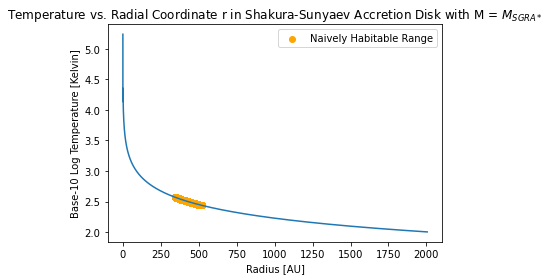

In [260]:
r = radius.to(units.AU)
naively_habitable_zone = np.logical_and(sampleBH.T<=373, sampleBH.T>=273)
habitable_T = np.where(naively_habitable_zone, sampleBH.T, np.zeros(sampleBH.T.size))
habitable_radii = np.where(naively_habitable_zone, r, np.zeros(sampleBH.T.size))
plt.plot(r, np.log10(sampleBH.T))
plt.scatter(habitable_radii, np.log10(habitable_T), c='orange', label = 'Naively Habitable Range')
plt.legend()
plt.ylabel('Base-10 Log Temperature [Kelvin]')
plt.xlabel('Radius [AU]')
plt.title(r'Temperature vs. Radial Coordinate r in Shakura-Sunyaev Accretion Disk with M = $M_{SGR A*}$')

In [21]:
"""
Variables for use later:

Mdot = -2*np.pi*Sigma*np.sqrt(Delta)*V/np.sqrt(1-V**2)
Delta = 1 #boilerplate for now just so code will run
        Sigma = 1 #boilerplate for now just so code will run
        V = 0.5 #boilerplate for now just so code will run

"""

'''
Typical Mdot range: [1e-9, 3e-8] solar masses per year (Shakura+Sunyaev 1973) 

Conversion to cgs: 6e16 g*s^-1 to 2e18 g*s^-1
'''
print((1e-9*units.M_sun/units.yr).cgs, (3e-8*units.M_sun/units.yr).cgs)

6.300890659296179e+16 g / s 1.8902671977888532e+18 g / s


<Quantity [1.00000000e+10, 3.10002900e+11, 6.10005800e+11, 9.10008700e+11,
           1.21001160e+12, 1.51001450e+12, 1.81001740e+12, 2.11002030e+12,
           2.41002320e+12, 2.71002610e+12, 3.01002900e+12, 3.31003190e+12,
           3.61003480e+12, 3.91003770e+12, 4.21004060e+12, 4.51004350e+12,
           4.81004640e+12, 5.11004930e+12, 5.41005220e+12, 5.71005510e+12,
           6.01005800e+12, 6.31006090e+12, 6.61006380e+12, 6.91006670e+12,
           7.21006960e+12, 7.51007250e+12, 7.81007540e+12, 8.11007830e+12,
           8.41008120e+12, 8.71008410e+12, 9.01008700e+12, 9.31008990e+12,
           9.61009280e+12, 9.91009570e+12, 1.02100986e+13, 1.05101015e+13,
           1.08101044e+13, 1.11101073e+13, 1.14101102e+13, 1.17101131e+13,
           1.20101160e+13, 1.23101189e+13, 1.26101218e+13, 1.29101247e+13,
           1.32101276e+13, 1.35101305e+13, 1.38101334e+13, 1.41101363e+13,
           1.44101392e+13, 1.47101421e+13, 1.50101450e+13, 1.53101479e+13,
           1.56101508e+13

In [201]:
 def debug(black_hole_mass, radius, region ='outer', angular_momentum=1e3, accretion_rate = 1e10, alpha = 0.02):
        Jstar = angular_momentum
        Mdot = accretion_rate
#         #initialize bulk parameters
#         #boilerplate for now just so code will run
        M = black_hole_mass
        scaled_M = black_hole_mass*G/c**2
        a = Jstar/(black_hole_mass*c)
        astar = a/scaled_M
        m = M/M_sun
        L_edd = 3.2e4*m*L_sun #assumes fully ionized hydrogen plasma, but this should suffice for OOM
        mdot = Mdot*(c**2)/L_edd
        rstar = radius*(c**2)/(G*M)
        y = (radius/scaled_M)**0.5
        A = 1+astar**2*y**-4+2*astar*y**-6
        B = 1+astar*y**-3
        C = 1-3*y**-2+2*astar*y**-3
        D = 1-2*y**-2+astar**2*y**-4
        E = 1+4*astar**2*y**-4-4*astar**2*y**-6+3*astar**4*y**-8
        Q0 = (1+astar*y**-3)/(y*(np.abs(1-3*y**-2+2*astar*y**-3))**0.5)
        r_G = G*black_hole_mass/c**2
        Z1 = 1+(1-astar**2)**(1/3)*((1+a)**(1/3)+(1-a)**(1/3))
        Z2 = (3*astar**2+Z1**2)**0.5
        r_ms = r_G*(3+Z2-((3-Z1)*(3+Z1+2*Z2)**0.5))
        y0 = (r_ms/scaled_M)**0.5 #y0 through 4 are constant floats
        y1 = 2*np.cos((np.arccos(astar)-np.pi)/3)
        y2 = 2*np.cos((np.arccos(astar)+np.pi)/3)
        y3 = -2*np.cos((np.arccos(astar))/3)
        Q = Q0*(y-y0-1.5*astar*np.log(y/y0)-3*(y1-astar)**2*np.log((y-y1)/(y0-y1))/(y1*(y1-y2)*(y1-y3))) - \
        Q0*(3*(y2-astar)**2/(y*(y2-y1)*(y2-y3))*np.log((y-y2)/(y0-y2))-\
        3*(y3-astar)**2*np.log((y-y3)/(y0-y3))/(y3*(y3-y1)*(y3-y1)))
        T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q**(3/10)
        return T
        #rho_cgs = 1
        #T_K = 1e5
        
#         """Use opacity assumptions from Abramowicz 29"""
#         #kappa_es = 0.34 #cm^2 g^-1
#         #kappa_ff = 6.4e22*rho_cgs*T_K**(-7/2) #same units as above; rho_cgs is density in g cm^-3, T_K is temp in Kelvin
#         if region == 'outer':
#             #self.kappa = kappa_ff
#             self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
#             self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
#             self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*A**(19/20)*B**(-11/10)*C**(1/2)*D**(-23/40)*E**(-19/40)*Q**(3/20)
#             #self.rhonaught = (4e2)*alpha**(-7/10)*m**(-7/10)*mdot**(3/20)*rstar**(-15/8)*A**(-17/20)*B**(3/10)*D**(-11/40)*E**(17/40)*Q(11/20)
#             self.T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q(3/10)
#         elif region == 'middle':
#             self.kappa = kappa_es
#             self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
#             self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
#             self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*A**(19/20)*B**(-11/10)*C**(1/2)*D**(-23/40)*E**(-19/40)*Q**(3/20)
#             self.rhonaught = (4e2)*alpha**(-7/10)*m**(-7/10)*mdot**(3/20)*rstar**(-15/8)*A**(-17/20)*B**(3/10)*D**(-11/40)*E**(17/40)*Q(11/20)
#             self.T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q(3/10)
#         elif region == 'inner':
#             self.kappa = kappa_es
#             self.F = (7e26)*(mdot/m)*(rstar**-3)*(B**-1)*(C**-0.5)*(Q)
#             self.Sigma = (4e5)*(alpha**(-0.1)*m**(0.2)*mdot**(0.7))*(rstar**(-3/4))*A**(0.1)*B**(-4/5)*C**(1/2)*D**(-17/20)*E**(-1/20)*Q**(7/10) #Sigma is the surface density
#             self.H = (4e2)*(alpha**(-0.1)*m**(18/20)*mdot**(3/20))*rstar**(9/8)*A**(19/20)*B**(-11/10)*C**(1/2)*D**(-23/40)*E**(-19/40)*Q**(3/20)
#             self.rhonaught = (4e2)*alpha**(-7/10)*m**(-7/10)*mdot**(3/20)*rstar**(-15/8)*A**(-17/20)*B**(3/10)*D**(-11/40)*E**(17/40)*Q(11/20)
#             self.T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q(3/10)
#         else:
#             pass

In [207]:
np.set_printoptions(threshold=np.inf)
T = debug(8.3e39, radius, accretion_rate = 6e17)


<ipython-input-201-430505077758>:29: RuntimeWarning: invalid value encountered in log
  Q = Q0*(y-y0-1.5*astar*np.log(y/y0)-3*(y1-astar)**2*np.log((y-y1)/(y0-y1))/(y1*(y1-y2)*(y1-y3))) - \
<ipython-input-201-430505077758>:32: RuntimeWarning: invalid value encountered in power
  T = (2e8)*(alpha**(-1/5)*m**(-1/5)*mdot**(3/10))*rstar**(-3/4)*A**(-1/10)*B**(-1/5)*D**(-3/20)*E**(1/20)*Q**(3/10)


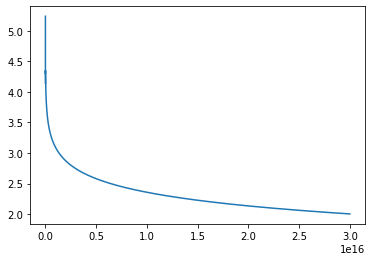

In [212]:
plt.plot(radius, np.log10(T))